# Zarr Dataset Exploration

This notebook explores the gameplay recordings converted to zarr format by `convert_to_zarr.py`.

The dataset contains:
- **Frames**: Video frames as `[N, C, H, W]` uint8 arrays
- **State**: Game state values as `[N, num_attributes]` float32 arrays
- **Actions**: Input actions as `[N, num_keys]` boolean arrays


In [68]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100


## 1. Load Dataset


In [42]:
# Path to your zarr dataset
dataset_path = Path('../dataset/margit_100_256x144_v2.zarr')  # Adjust this path as needed

# Open zarr dataset
zarr_root = zarr.open(str(dataset_path), mode='r')

print(f"Dataset loaded from: {dataset_path}")
print(f"\nDataset keys: {list(zarr_root.keys())}")


Dataset loaded from: ../dataset/margit_100_256x144_v2.zarr

Dataset keys: ['episode_0', 'episode_1', 'episode_10', 'episode_11', 'episode_12', 'episode_13', 'episode_14', 'episode_15', 'episode_16', 'episode_17', 'episode_18', 'episode_19', 'episode_2', 'episode_20', 'episode_21', 'episode_22', 'episode_23', 'episode_24', 'episode_25', 'episode_26', 'episode_27', 'episode_28', 'episode_29', 'episode_3', 'episode_30', 'episode_31', 'episode_32', 'episode_33', 'episode_34', 'episode_35', 'episode_36', 'episode_37', 'episode_38', 'episode_39', 'episode_4', 'episode_40', 'episode_41', 'episode_42', 'episode_43', 'episode_44', 'episode_45', 'episode_46', 'episode_47', 'episode_48', 'episode_49', 'episode_5', 'episode_50', 'episode_51', 'episode_52', 'episode_53', 'episode_54', 'episode_55', 'episode_56', 'episode_57', 'episode_58', 'episode_59', 'episode_6', 'episode_60', 'episode_61', 'episode_62', 'episode_63', 'episode_64', 'episode_65', 'episode_66', 'episode_67', 'episode_68', 'episode

## 2. Dataset Metadata


In [43]:
# Print global metadata
print("Global Metadata:")
for key, value in zarr_root.attrs.items():
    if key not in ['keys', 'attributes', 'raw_to_semantic']:  # Print these separately
        print(f"  {key}: {value}")

# Number of episodes
episodes = [k for k in zarr_root.keys() if k.startswith('episode_')]
print(f"\nNumber of episodes: {len(episodes)}")


Global Metadata:
  format: framewise
  source: recordings
  target_resolution: [256, 144]
  version: 1.0

Number of episodes: 100


In [44]:
# Action keys (semantic names)
if 'keys' in zarr_root.attrs:
    action_keys = zarr_root.attrs['keys']
    print(f"Action Keys ({len(action_keys)}):")
    for i, key in enumerate(action_keys):
        print(f"  [{i:2d}] {key}")


Action Keys (13):
  [ 0] move_forward
  [ 1] move_back
  [ 2] move_left
  [ 3] move_right
  [ 4] dodge_roll/dash
  [ 5] jump
  [ 6] crouch/standup
  [ 7] lock_on
  [ 8] attack
  [ 9] strong_attack
  [10] skill
  [11] use_item
  [12] event_action


In [45]:
# State attributes
if 'attributes' in zarr_root.attrs:
    state_attrs = zarr_root.attrs['attributes']
    print(f"State Attributes ({len(state_attrs)}):")
    for i, attr in enumerate(state_attrs):
        print(f"  [{i:2d}] {attr}")


State Attributes (19):
  [ 0] HeroHp
  [ 1] HeroMaxHp
  [ 2] HeroSp
  [ 3] HeroMaxSp
  [ 4] HeroFp
  [ 5] HeroMaxFp
  [ 6] HeroGlobalPosX
  [ 7] HeroGlobalPosY
  [ 8] HeroGlobalPosZ
  [ 9] HeroAngle
  [10] HeroAnimId
  [11] NpcHp
  [12] NpcMaxHp
  [13] NpcId
  [14] NpcGlobalPosX
  [15] NpcGlobalPosY
  [16] NpcGlobalPosZ
  [17] NpcGlobalPosAngle
  [18] NpcAnimId


## 3. Episode Information


In [46]:
# Select episode to explore
episode_idx = 0
episode = zarr_root[f'episode_{episode_idx}']

print(f"Episode {episode_idx} Information:")
print(f"  Session name: {episode.attrs.get('session_name', 'N/A')}")
print(f"  FPS: {episode.attrs.get('fps', 'N/A')}")
print(f"  Frame count: {episode.attrs.get('frame_count', 'N/A')}")
print(f"  Original resolution: {episode.attrs.get('original_resolution', 'N/A')}")
print(f"  Stored resolution: {episode.attrs.get('stored_resolution', 'N/A')}")

print(f"\nData shapes:")
print(f"  Frames: {episode['frames'].shape} ({episode['frames'].dtype})")
print(f"  State: {episode['state'].shape} ({episode['state'].dtype})")
print(f"  Actions: {episode['actions'].shape} ({episode['actions'].dtype})")


Episode 0 Information:
  Session name: rec_1765099308014_7816
  FPS: 17.077590858256954
  Frame count: 1053
  Original resolution: [2160, 3840]
  Stored resolution: [144, 256]

Data shapes:
  Frames: (1053, 3, 144, 256) (uint8)
  State: (1053, 19) (float32)
  Actions: (1053, 13) (bool)


## 4. Visualize Frames


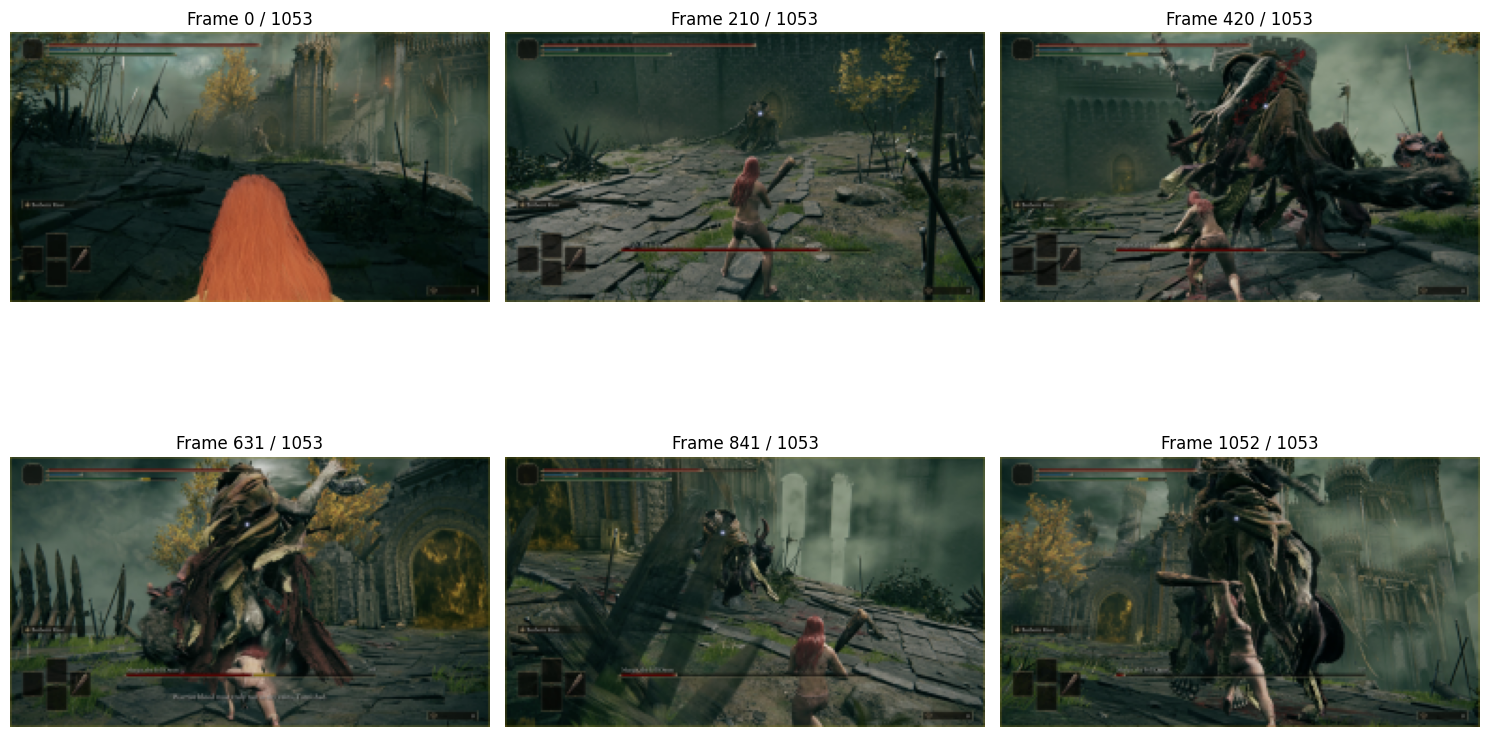

In [47]:
# Display a few frames from the episode
num_frames_to_show = 6
total_frames = episode['frames'].shape[0]
frame_indices = np.linspace(0, total_frames - 1, num_frames_to_show, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frame_idx in enumerate(frame_indices):
    # Load frame (shape: [C, H, W])
    frame = episode['frames'][frame_idx]
    
    # Convert from CHW to HWC for display
    frame_hwc = np.transpose(frame, (1, 2, 0))
    
    # Convert BGR to RGB (OpenCV uses BGR)
    frame_rgb = frame_hwc[:, :, ::-1]
    
    axes[i].imshow(frame_rgb)
    axes[i].set_title(f'Frame {frame_idx} / {total_frames}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 5. Explore Actions Over Time


Actions shape: (1053, 13)
Action keys: ['move_forward', 'move_back', 'move_left', 'move_right', 'dodge_roll/dash', 'jump', 'crouch/standup', 'lock_on', 'attack', 'strong_attack', 'skill', 'use_item', 'event_action']


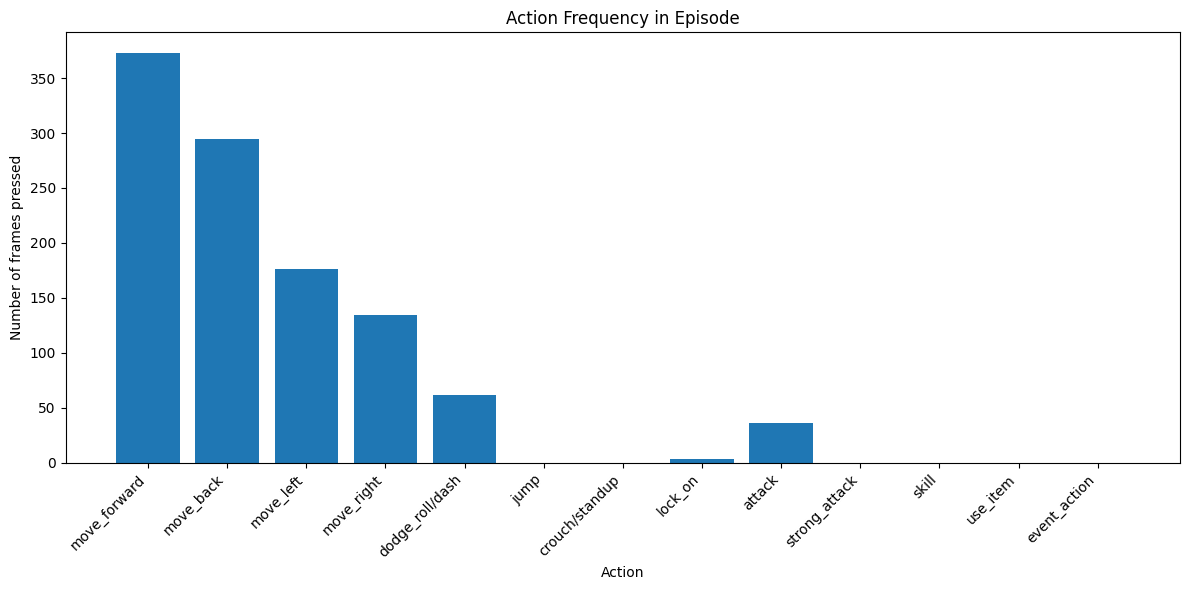

In [48]:
# Get actions data
actions = episode['actions'][:]
action_keys = episode.attrs.get('action_keys', zarr_root.attrs.get('keys', []))

print(f"Actions shape: {actions.shape}")
print(f"Action keys: {action_keys}")

# Count how often each action is pressed
action_counts = actions.sum(axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(action_keys)), action_counts)
plt.xlabel('Action')
plt.ylabel('Number of frames pressed')
plt.title('Action Frequency in Episode')
plt.xticks(range(len(action_keys)), action_keys, rotation=45, ha='right')
plt.tight_layout()
plt.show()


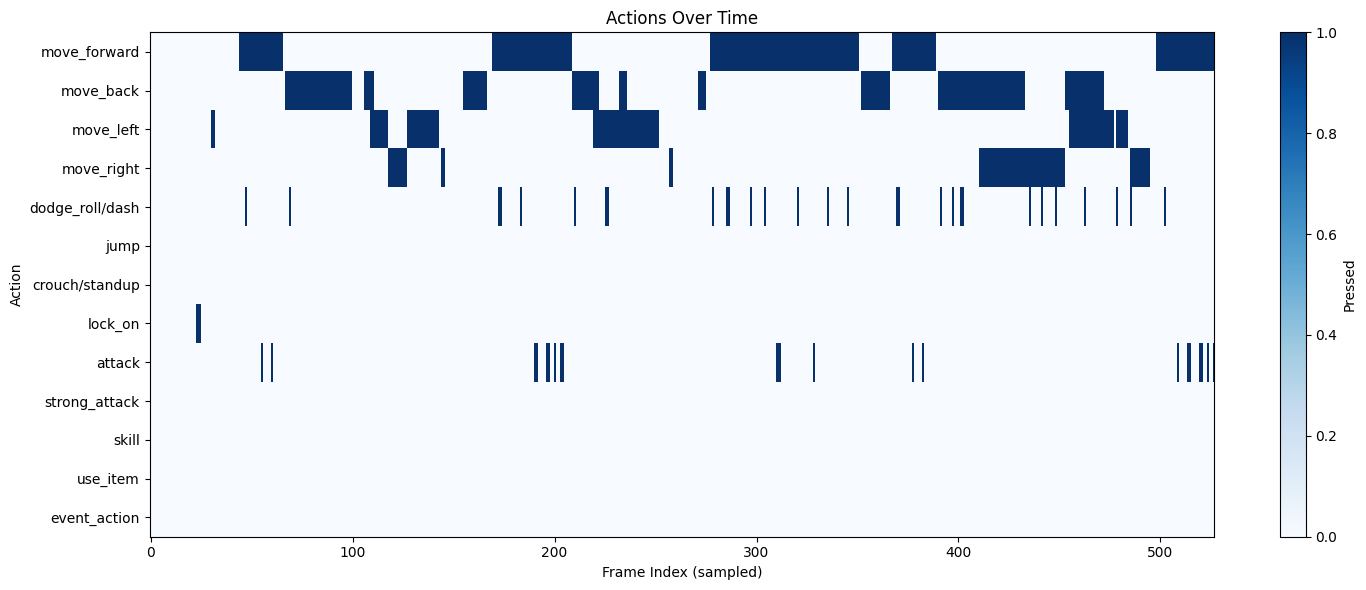

In [49]:
# Plot actions over time (heatmap)
# Sample every N frames for better visualization
sample_rate = max(1, actions.shape[0] // 500)
actions_sampled = actions[::sample_rate, :]

plt.figure(figsize=(15, 6))
plt.imshow(actions_sampled.T, aspect='auto', cmap='Blues', interpolation='nearest')
plt.colorbar(label='Pressed')
plt.xlabel('Frame Index (sampled)')
plt.ylabel('Action')
plt.title('Actions Over Time')
plt.yticks(range(len(action_keys)), action_keys)
plt.tight_layout()
plt.show()


## 6. Explore State Over Time


In [50]:
# Get state data
state = episode['state'][:]
state_attrs = episode.attrs.get('state_attributes', zarr_root.attrs.get('attributes', []))

print(f"State shape: {state.shape}")
print(f"State attributes: {state_attrs}")

# Print basic statistics for each attribute
print("\nState Statistics:")
for i, attr in enumerate(state_attrs):
    values = state[:, i]
    print(f"  {attr:20s}: min={values.min():10.2f}, max={values.max():10.2f}, mean={values.mean():10.2f}, std={values.std():10.2f}")


State shape: (1053, 19)
State attributes: ['HeroHp', 'HeroMaxHp', 'HeroSp', 'HeroMaxSp', 'HeroFp', 'HeroMaxFp', 'HeroGlobalPosX', 'HeroGlobalPosY', 'HeroGlobalPosZ', 'HeroAngle', 'HeroAnimId', 'NpcHp', 'NpcMaxHp', 'NpcId', 'NpcGlobalPosX', 'NpcGlobalPosY', 'NpcGlobalPosZ', 'NpcGlobalPosAngle', 'NpcAnimId']

State Statistics:
  HeroHp              : min=   1571.00, max=   2100.00, mean=   1893.88, std=    229.01
  HeroMaxHp           : min=   2100.00, max=   2100.00, mean=   2100.00, std=      0.00
  HeroSp              : min=     99.00, max=    170.00, mean=    153.22, std=     19.24
  HeroMaxSp           : min=    170.00, max=    170.00, mean=    170.00, std=      0.00
  HeroFp              : min=     78.00, max=     78.00, mean=     78.00, std=      0.00
  HeroMaxFp           : min=     78.00, max=     78.00, mean=     78.00, std=      0.00
  HeroGlobalPosX      : min=    -31.17, max=     18.69, mean=    -15.05, std=     10.93
  HeroGlobalPosY      : min=    -26.10, max=    -11.95, m

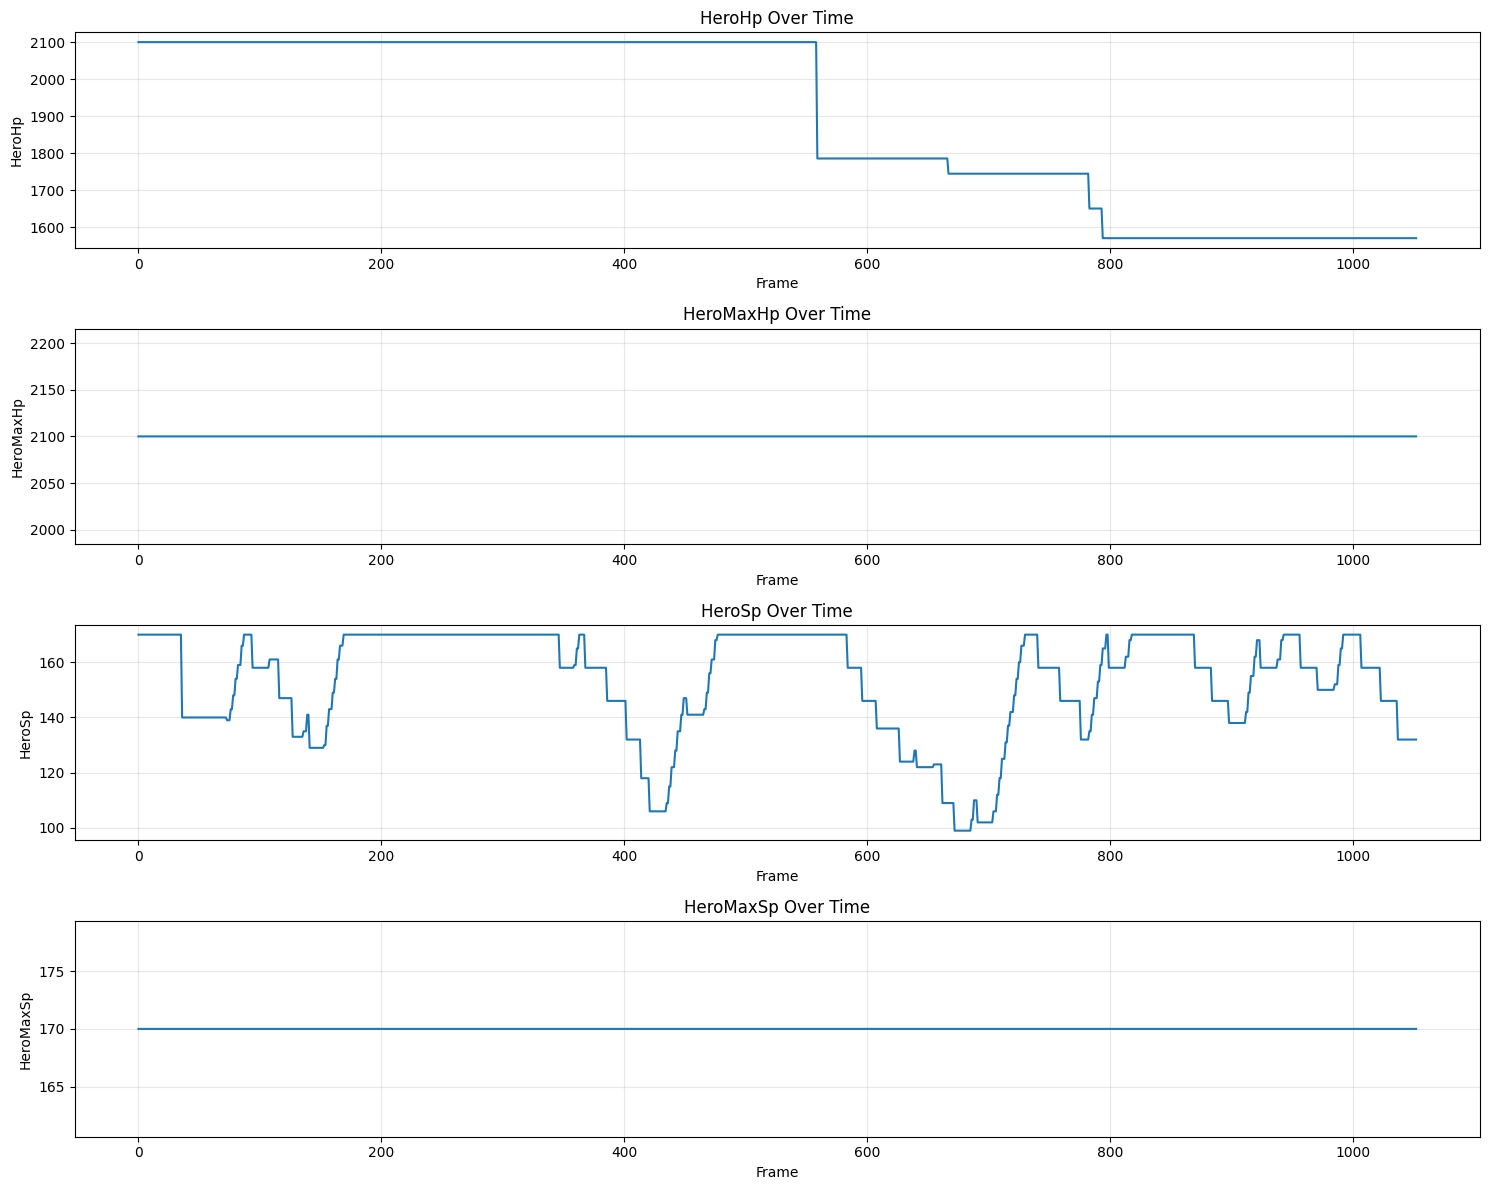

In [51]:
# Plot first few state attributes over time
num_attrs_to_plot = min(4, len(state_attrs))

fig, axes = plt.subplots(num_attrs_to_plot, 1, figsize=(15, 3 * num_attrs_to_plot))
if num_attrs_to_plot == 1:
    axes = [axes]

for i in range(num_attrs_to_plot):
    axes[i].plot(state[:, i])
    axes[i].set_ylabel(state_attrs[i])
    axes[i].set_xlabel('Frame')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title(f'{state_attrs[i]} Over Time')

plt.tight_layout()
plt.show()


## 7. Correlate Actions with State Changes


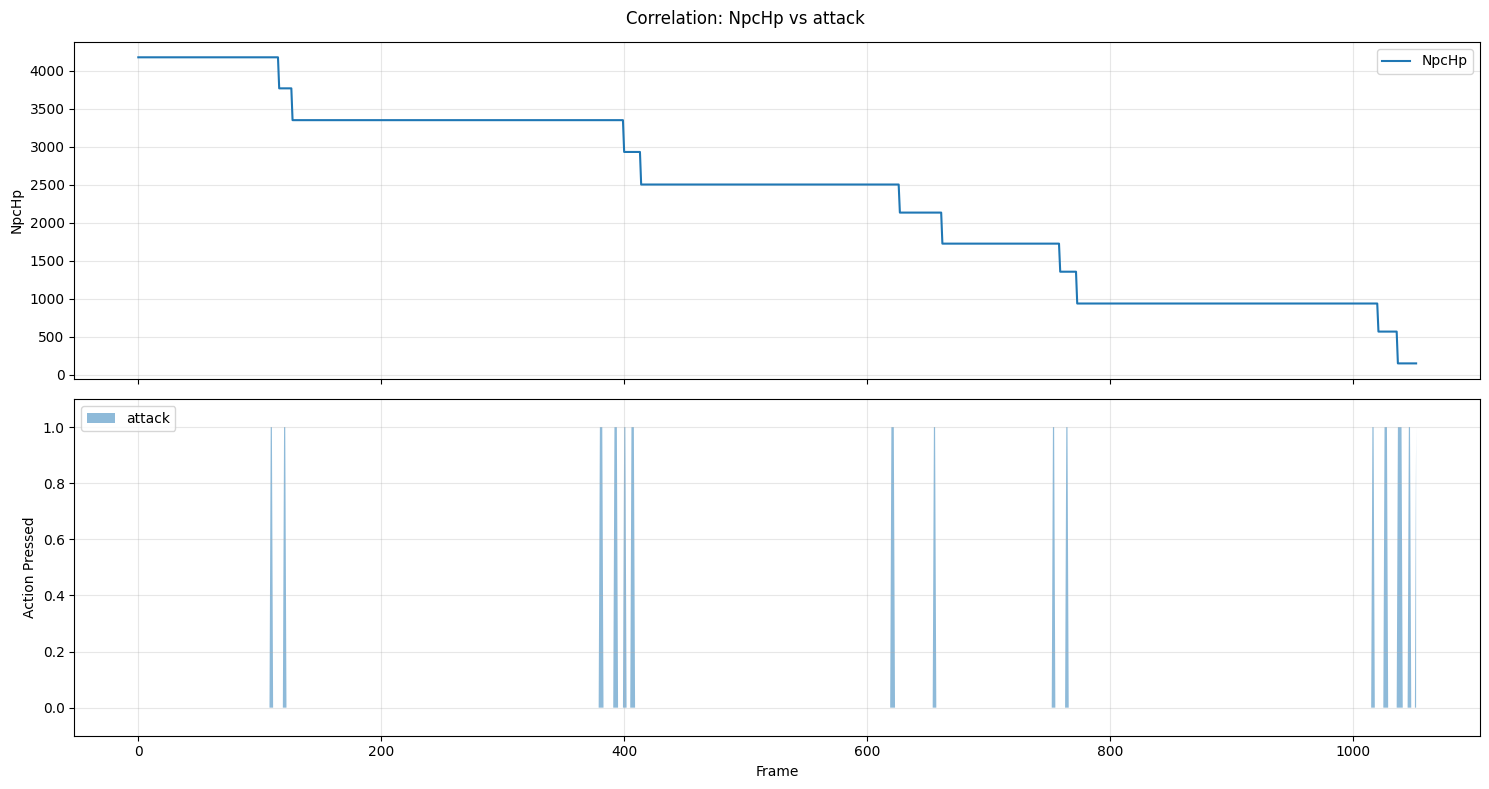

In [52]:
# Example: Look at a specific state attribute when certain actions are pressed
# Let's pick the first state attribute and first action as an example

if len(action_keys) > 0 and len(state_attrs) > 0:
    action_idx = 8
    state_idx = 11
    
    action_name = action_keys[action_idx]
    state_name = state_attrs[state_idx]
    
    # Get frames where action is pressed
    action_pressed = actions[:, action_idx]
    state_values = state[:, state_idx]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Plot state
    ax1.plot(state_values, label=state_name)
    ax1.set_ylabel(state_name)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot action
    ax2.fill_between(range(len(action_pressed)), 0, action_pressed, alpha=0.5, label=action_name)
    ax2.set_ylabel('Action Pressed')
    ax2.set_xlabel('Frame')
    ax2.set_ylim([-0.1, 1.1])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Correlation: {state_name} vs {action_name}')
    plt.tight_layout()
    plt.show()
else:
    print("No actions or state attributes to compare")


## 8. Summary Statistics Across All Episodes


In [53]:
# Collect statistics from all episodes
import pandas as pd

episode_stats = []

for ep_name in sorted(episodes):
    ep = zarr_root[ep_name]
    stats = {
        'episode': ep_name,
        'frames': ep['frames'].shape[0],
        'fps': ep.attrs.get('fps', 'N/A'),
        'duration_sec': ep['frames'].shape[0] / ep.attrs.get('fps', 1) if ep.attrs.get('fps') else 'N/A',
        'total_actions': ep['actions'][:].sum(),
    }
    episode_stats.append(stats)

# Display as table
df_stats = pd.DataFrame(episode_stats)
print("Episode Statistics:")
print(df_stats.to_string(index=False))

# Summary
print("\nTotal Statistics:")
print(f"  Total frames: {df_stats['frames'].sum()}")
if df_stats['duration_sec'].dtype != 'object':
    print(f"  Total duration: {df_stats['duration_sec'].sum():.2f} seconds")
print(f"  Total actions: {df_stats['total_actions'].sum()}")


Episode Statistics:
   episode  frames       fps  duration_sec  total_actions
 episode_0    1053 17.077591     61.659751           1079
 episode_1     933 17.223023     54.171675            959
episode_10     808 17.228628     46.898684            632
episode_11     863 17.183085     50.223810            735
episode_12    1248 17.228213     72.439320            913
episode_13     762 17.245999     44.184162            488
episode_14    1057 17.361258     60.882684            781
episode_15     661 17.190003     38.452582            526
episode_16    1282 17.276816     74.203488           1026
episode_17     731 17.136642     42.657132            699
episode_18     787 17.310640     45.463367            784
episode_19     881 17.130831     51.427745            707
 episode_2     559 17.307440     32.298248            579
episode_20     978 17.209648     56.828587            845
episode_21     906 17.424200     51.996648            814
episode_22     867 17.275646     50.186257          

In [54]:
# ============================================
# 9. Dodge vs NPC Animation Correlation Analysis
# ============================================
# Analyze whether dodge actions correlate with specific NPC attack animations

import pandas as pd
from collections import Counter

# Indices
DODGE_IDX = 4  # dodge_roll/dash
NPC_ANIM_IDX = 18  # NpcAnimId in state

# Collect data across all episodes
all_npc_anims = []
all_dodges = []
npc_anim_when_dodge = []
npc_anim_before_dodge = []  # Look at frames before dodge

LOOKBACK = 10  # How many frames before dodge to look at

for ep_name in sorted(episodes):
    ep = zarr_root[ep_name]
    actions = ep['actions'][:]
    state = ep['state'][:]
    
    npc_anims = state[:, NPC_ANIM_IDX].astype(int)
    dodges = actions[:, DODGE_IDX]
    
    all_npc_anims.extend(npc_anims.tolist())
    all_dodges.extend(dodges.tolist())
    
    # Get NPC anim when dodge is pressed
    dodge_frames = np.where(dodges)[0]
    for df in dodge_frames:
        npc_anim_when_dodge.append(npc_anims[df])
        # Also get anims in lookback window
        for lb in range(1, LOOKBACK + 1):
            if df - lb >= 0:
                npc_anim_before_dodge.append((lb, npc_anims[df - lb]))

print(f"Total frames analyzed: {len(all_npc_anims)}")
print(f"Total dodge frames: {len(npc_anim_when_dodge)}")
print(f"Dodge rate: {len(npc_anim_when_dodge) / len(all_npc_anims) * 100:.2f}%")

Total frames analyzed: 94798
Total dodge frames: 5859
Dodge rate: 6.18%


In [55]:
# Count NPC animations overall vs during dodge
overall_anim_counts = Counter(all_npc_anims)
dodge_anim_counts = Counter(npc_anim_when_dodge)

# Get unique animations
all_unique_anims = set(overall_anim_counts.keys())
print(f"Unique NPC animations: {len(all_unique_anims)}")

# Calculate P(dodge | anim) for each animation
# P(dodge | anim) = count(dodge & anim) / count(anim)
dodge_given_anim = {}
for anim in all_unique_anims:
    if overall_anim_counts[anim] > 0:
        dodge_given_anim[anim] = dodge_anim_counts.get(anim, 0) / overall_anim_counts[anim]

# Sort by dodge probability
sorted_anims = sorted(dodge_given_anim.items(), key=lambda x: x[1], reverse=True)

# Show top animations that trigger dodge
print("\n=== Top 20 NPC Animations with Highest Dodge Rate ===")
print(f"{'Anim ID':>12} | {'Dodge Rate':>10} | {'Total Count':>12} | {'Dodge Count':>12}")
print("-" * 55)
for anim, rate in sorted_anims[:20]:
    total = overall_anim_counts[anim]
    dodge_count = dodge_anim_counts.get(anim, 0)
    if total >= 50:  # Filter for anims with enough samples
        print(f"{anim:>12} | {rate:>10.2%} | {total:>12} | {dodge_count:>12}")

Unique NPC animations: 53

=== Top 20 NPC Animations with Highest Dodge Rate ===
     Anim ID | Dodge Rate |  Total Count |  Dodge Count
-------------------------------------------------------
     2003030 |     16.01% |          406 |           65
     2003003 |     15.08% |          126 |           19
     2003017 |     13.88% |         6015 |          835
     2003005 |     13.39% |          112 |           15
     2003034 |     13.35% |         1101 |          147
     2003033 |     13.06% |         1998 |          261
     2003000 |     12.69% |         1749 |          222
     2003014 |     11.84% |          456 |           54
     2003020 |     10.43% |          211 |           22
     2003016 |     10.41% |         1028 |          107
     2003018 |     10.36% |          280 |           29
     2003032 |     10.20% |          608 |           62
     2003010 |      9.45% |         1217 |          115
     2003001 |      9.05% |          409 |           37
     2003006 |      8.9

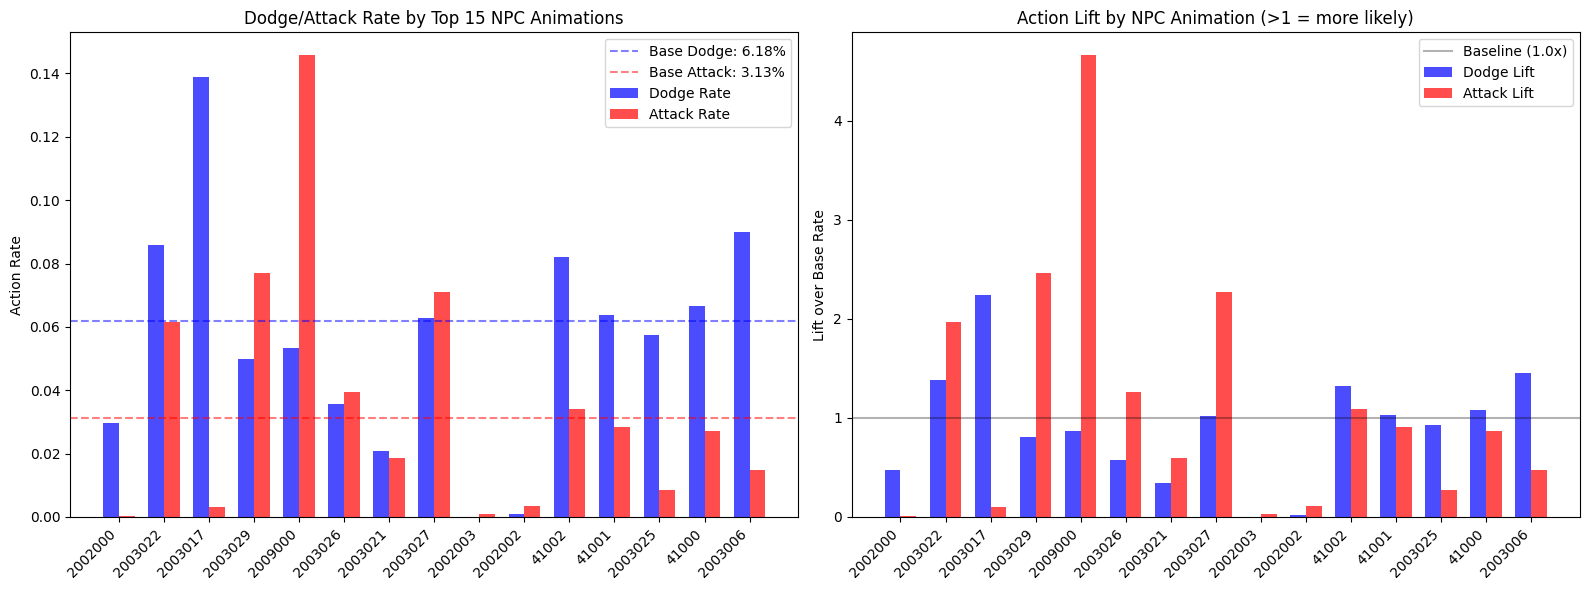


=== CONCLUSION ===
Max dodge lift: 2.25x (Anim 2003017)
Max attack lift: 4.66x (Anim 2009000)

If lift is close to 1.0 for all animations, NPC animation is NOT predictive of dodge/attack.
If some animations have lift >> 1.0, the model SHOULD be able to learn this correlation.


In [56]:
# Summary visualization: Compare dodge/attack rates for key animations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get top 15 animations by total count
top_15 = [a for a, _ in overall_anim_counts.most_common(15)]

# Dodge rates
dodge_rates = [dodge_given_anim.get(a, 0) for a in top_15]
attack_rates = [attack_given_anim.get(a, 0) for a in top_15]

x = np.arange(len(top_15))
width = 0.35

# Plot 1: Side by side
axes[0].bar(x - width/2, dodge_rates, width, label='Dodge Rate', color='blue', alpha=0.7)
axes[0].bar(x + width/2, attack_rates, width, label='Attack Rate', color='red', alpha=0.7)
axes[0].axhline(y=base_dodge_rate, color='blue', linestyle='--', alpha=0.5, label=f'Base Dodge: {base_dodge_rate:.2%}')
base_attack_rate = len(npc_anim_when_attack) / len(all_npc_anims)
axes[0].axhline(y=base_attack_rate, color='red', linestyle='--', alpha=0.5, label=f'Base Attack: {base_attack_rate:.2%}')
axes[0].set_xticks(x)
axes[0].set_xticklabels([str(a) for a in top_15], rotation=45, ha='right')
axes[0].set_ylabel('Action Rate')
axes[0].set_title('Dodge/Attack Rate by Top 15 NPC Animations')
axes[0].legend()

# Plot 2: Lift over base rate
dodge_lift = [r / base_dodge_rate if base_dodge_rate > 0 else 0 for r in dodge_rates]
attack_lift = [r / base_attack_rate if base_attack_rate > 0 else 0 for r in attack_rates]

axes[1].bar(x - width/2, dodge_lift, width, label='Dodge Lift', color='blue', alpha=0.7)
axes[1].bar(x + width/2, attack_lift, width, label='Attack Lift', color='red', alpha=0.7)
axes[1].axhline(y=1.0, color='black', linestyle='-', alpha=0.3, label='Baseline (1.0x)')
axes[1].set_xticks(x)
axes[1].set_xticklabels([str(a) for a in top_15], rotation=45, ha='right')
axes[1].set_ylabel('Lift over Base Rate')
axes[1].set_title('Action Lift by NPC Animation (>1 = more likely)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n=== CONCLUSION ===")
max_dodge_lift = max(dodge_lift)
max_attack_lift = max(attack_lift)
print(f"Max dodge lift: {max_dodge_lift:.2f}x (Anim {top_15[dodge_lift.index(max_dodge_lift)]})")
print(f"Max attack lift: {max_attack_lift:.2f}x (Anim {top_15[attack_lift.index(max_attack_lift)]})")
print(f"\nIf lift is close to 1.0 for all animations, NPC animation is NOT predictive of dodge/attack.")
print(f"If some animations have lift >> 1.0, the model SHOULD be able to learn this correlation.")

In [57]:
# Statistical summary: How much does NPC animation predict dodge/attack?
from scipy import stats

# Create binary arrays for correlation
all_npc_anims_arr = np.array(all_npc_anims)
all_dodges_arr = np.array(all_dodges).astype(float)

# One-hot encode NPC animations (top 20 most common)
top_anims = [a for a, _ in overall_anim_counts.most_common(20)]
print("=== Correlation: NPC Animation → Dodge ===")
print(f"{'Anim ID':>12} | {'Point-Biserial r':>16} | {'p-value':>12} | {'Significant':>12}")
print("-" * 60)

significant_anims = []
for anim in top_anims:
    anim_binary = (all_npc_anims_arr == anim).astype(float)
    r, p = stats.pointbiserialr(anim_binary, all_dodges_arr)
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
    print(f"{anim:>12} | {r:>16.4f} | {p:>12.2e} | {sig:>12}")
    if p < 0.05 and abs(r) > 0.02:
        significant_anims.append((anim, r))

print(f"\n{len(significant_anims)} animations significantly correlated with dodge (p<0.05, |r|>0.02)")

=== Correlation: NPC Animation → Dodge ===
     Anim ID | Point-Biserial r |      p-value |  Significant
------------------------------------------------------------
     2002000 |          -0.0520 |     8.45e-58 |          ***
     2003022 |           0.0265 |     3.46e-16 |          ***
     2003017 |           0.0832 |    2.21e-145 |          ***
     2003029 |          -0.0123 |     1.58e-04 |          ***
     2009000 |          -0.0083 |     1.05e-02 |            *
     2003026 |          -0.0255 |     4.31e-15 |          ***
     2003021 |          -0.0396 |     3.47e-34 |          ***
     2003027 |           0.0009 |     7.74e-01 |             
     2002003 |          -0.0535 |     5.22e-61 |          ***
     2002002 |          -0.0516 |     5.91e-57 |          ***
       41002 |           0.0158 |     1.08e-06 |          ***
       41001 |           0.0014 |     6.75e-01 |             
     2003025 |          -0.0032 |     3.21e-01 |             
       41000 |           0.0

In [58]:
# Same analysis for ATTACK action
ATTACK_IDX = 8  # attack

npc_anim_when_attack = []
npc_anim_before_attack = []

for ep_name in sorted(episodes):
    ep = zarr_root[ep_name]
    actions = ep['actions'][:]
    state = ep['state'][:]
    
    npc_anims = state[:, NPC_ANIM_IDX].astype(int)
    attacks = actions[:, ATTACK_IDX]
    
    attack_frames = np.where(attacks)[0]
    for af in attack_frames:
        npc_anim_when_attack.append(npc_anims[af])
        for lb in range(1, LOOKBACK + 1):
            if af - lb >= 0:
                npc_anim_before_attack.append((lb, npc_anims[af - lb]))

attack_anim_counts = Counter(npc_anim_when_attack)

# Calculate P(attack | anim)
attack_given_anim = {}
for anim in all_unique_anims:
    if overall_anim_counts[anim] > 0:
        attack_given_anim[anim] = attack_anim_counts.get(anim, 0) / overall_anim_counts[anim]

sorted_attack_anims = sorted(attack_given_anim.items(), key=lambda x: x[1], reverse=True)

print(f"Total attack frames: {len(npc_anim_when_attack)}")
print(f"\n=== Top 20 NPC Animations with Highest Attack Rate ===")
print(f"{'Anim ID':>12} | {'Attack Rate':>10} | {'Total Count':>12} | {'Attack Count':>12}")
print("-" * 55)
for anim, rate in sorted_attack_anims[:20]:
    total = overall_anim_counts[anim]
    attack_count = attack_anim_counts.get(anim, 0)
    if total >= 50:
        print(f"{anim:>12} | {rate:>10.2%} | {total:>12} | {attack_count:>12}")

Total attack frames: 2963

=== Top 20 NPC Animations with Highest Attack Rate ===
     Anim ID | Attack Rate |  Total Count | Attack Count
-------------------------------------------------------
     2009000 |     14.57% |         5093 |          742
     2003029 |      7.71% |         5563 |          429
     2003027 |      7.11% |         4570 |          325
     2003022 |      6.15% |         6273 |          386
     2003039 |      5.00% |          100 |            5
     2003038 |      4.46% |          269 |           12
     2003026 |      3.93% |         4959 |          195
     2003008 |      3.87% |         2118 |           82
     2003012 |      3.71% |          512 |           19
       41002 |      3.41% |         3283 |          112
     2003030 |      3.20% |          406 |           13
     2003014 |      2.85% |          456 |           13
       41001 |      2.84% |         3066 |           87
     2003009 |      2.84% |         1446 |           41
       41000 |      2

In [59]:
# Lookback analysis: What NPC animations appear BEFORE a dodge?
# This tells us if there's a predictive signal

# Group by lookback frames
lookback_anims = {i: [] for i in range(1, LOOKBACK + 1)}
for lb, anim in npc_anim_before_dodge:
    lookback_anims[lb].append(anim)

# For each lookback, find most common anims
print("=== NPC Animations Before Dodge (by frames before) ===\n")
for lb in [1, 3, 5, 8, 10]:
    if lb <= LOOKBACK:
        counts = Counter(lookback_anims[lb])
        total = len(lookback_anims[lb])
        print(f"--- {lb} frame(s) before dodge ---")
        for anim, count in counts.most_common(5):
            pct = count / total * 100
            # Also show how this compares to overall rate for this anim
            overall_pct = overall_anim_counts[anim] / len(all_npc_anims) * 100
            lift = pct / overall_pct if overall_pct > 0 else 0
            print(f"  Anim {anim}: {pct:.1f}% (overall: {overall_pct:.1f}%, lift: {lift:.2f}x)")
        print()

=== NPC Animations Before Dodge (by frames before) ===

--- 1 frame(s) before dodge ---
  Anim 2003017: 14.2% (overall: 6.3%, lift: 2.24x)
  Anim 2003022: 9.2% (overall: 6.6%, lift: 1.39x)
  Anim 2002000: 6.4% (overall: 13.1%, lift: 0.49x)
  Anim 2003027: 4.9% (overall: 4.8%, lift: 1.02x)
  Anim 2009000: 4.9% (overall: 5.4%, lift: 0.91x)

--- 3 frame(s) before dodge ---
  Anim 2003017: 14.1% (overall: 6.3%, lift: 2.22x)
  Anim 2003022: 9.2% (overall: 6.6%, lift: 1.39x)
  Anim 2002000: 6.6% (overall: 13.1%, lift: 0.50x)
  Anim 2009000: 4.9% (overall: 5.4%, lift: 0.92x)
  Anim 2003027: 4.9% (overall: 4.8%, lift: 1.02x)

--- 5 frame(s) before dodge ---
  Anim 2003017: 14.0% (overall: 6.3%, lift: 2.20x)
  Anim 2003022: 9.1% (overall: 6.6%, lift: 1.38x)
  Anim 2002000: 6.8% (overall: 13.1%, lift: 0.52x)
  Anim 2009000: 5.2% (overall: 5.4%, lift: 0.96x)
  Anim 2003027: 4.9% (overall: 4.8%, lift: 1.02x)

--- 8 frame(s) before dodge ---
  Anim 2003017: 13.9% (overall: 6.3%, lift: 2.19x)
  Anim

Base dodge rate (overall): 6.18%


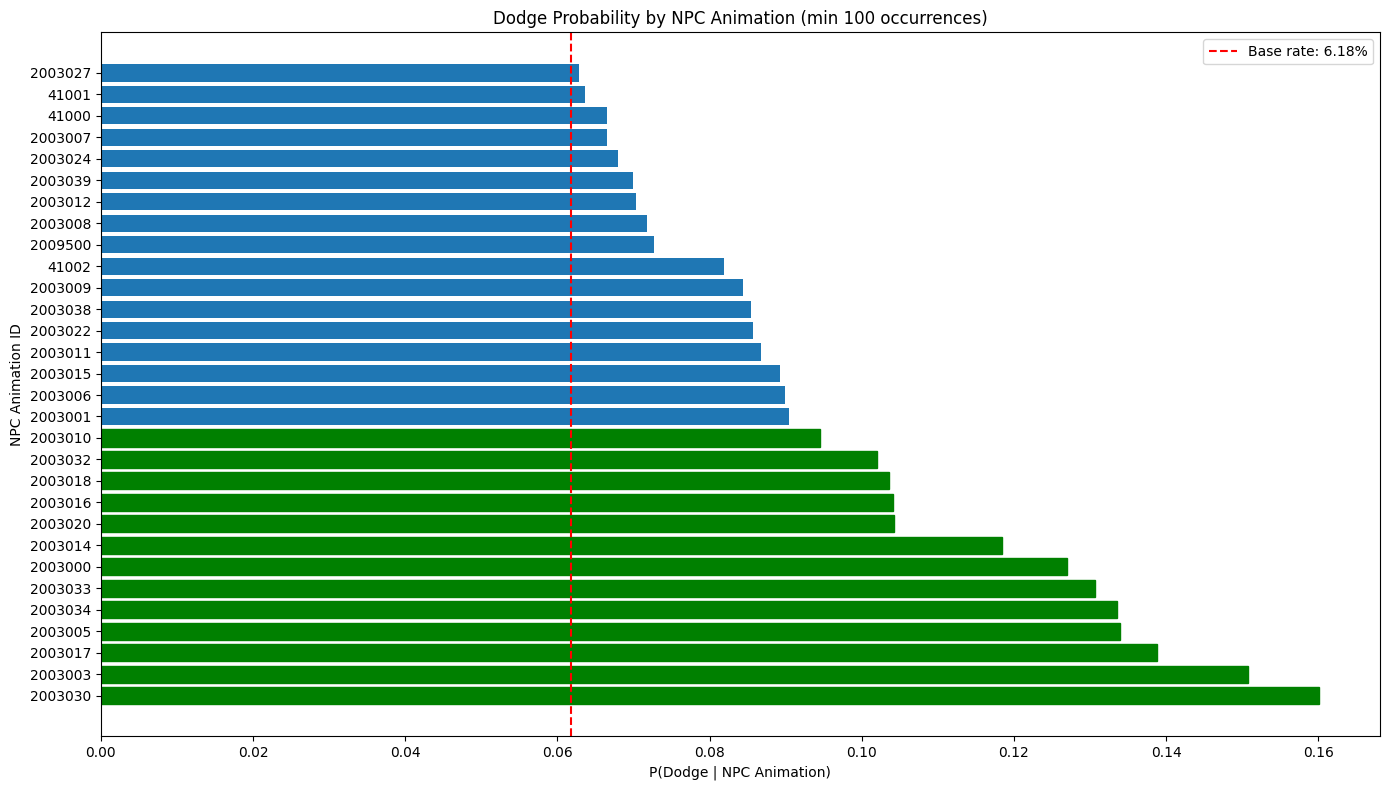

In [60]:
# Visualization: Dodge rate by NPC animation
# Filter to animations with at least 100 occurrences
min_count = 100
filtered_anims = [(a, r) for a, r in sorted_anims if overall_anim_counts[a] >= min_count]

# Base dodge rate (overall)
base_dodge_rate = sum(all_dodges) / len(all_dodges)
print(f"Base dodge rate (overall): {base_dodge_rate:.2%}")

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
anims = [str(a) for a, _ in filtered_anims[:30]]
rates = [r for _, r in filtered_anims[:30]]

bars = ax.barh(anims, rates)
ax.axvline(x=base_dodge_rate, color='red', linestyle='--', label=f'Base rate: {base_dodge_rate:.2%}')
ax.set_xlabel('P(Dodge | NPC Animation)')
ax.set_ylabel('NPC Animation ID')
ax.set_title('Dodge Probability by NPC Animation (min 100 occurrences)')
ax.legend()

# Color bars above/below base rate
for bar, rate in zip(bars, rates):
    if rate > base_dodge_rate * 1.5:  # Significantly above
        bar.set_color('green')
    elif rate < base_dodge_rate * 0.5:  # Significantly below
        bar.set_color('lightgray')

plt.tight_layout()
plt.show()

In [65]:
# ============================================
# 10. Optical Flow Analysis
# ============================================
# Visualize motion patterns before dodge vs normal frames

import cv2

def compute_optical_flow(frame1, frame2):
    """Compute dense optical flow between two frames.
    
    Returns:
        flow: [H, W, 2] array of (dx, dy) vectors
        magnitude: [H, W] motion magnitude
        angle: [H, W] motion direction
    """
    # Convert to grayscale (frames are [C, H, W] in BGR)
    gray1 = cv2.cvtColor(frame1.transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2.transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
    
    # Compute dense optical flow (Farneback method)
    flow = cv2.calcOpticalFlowFarneback(
        gray1, gray2,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    
    # Convert to polar coordinates
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    return flow, magnitude, angle

def flow_to_rgb(flow, magnitude):
    """Convert optical flow to RGB visualization (HSV color wheel)."""
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Hue = direction, Saturation = 255, Value = magnitude
    hsv[..., 0] = (np.arctan2(flow[..., 1], flow[..., 0]) * 180 / np.pi / 2).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = np.clip(magnitude * 10, 0, 255).astype(np.uint8)  # Scale magnitude
    
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

print("Optical flow functions defined.")

Optical flow functions defined.


In [66]:
# Find dodge onset frames for optical flow analysis
DODGE_IDX_FLOW = 4  # dodge_roll/dash - check your dataset's index

# Collect some dodge onset examples
dodge_examples = []  # (ep_name, onset_frame)
no_dodge_examples = []

for ep_name in episodes[:20]:  # First 20 episodes
    ep = zarr_root[ep_name]
    actions = ep['actions'][:]
    
    # Find dodge onsets
    prev_dodge = False
    for i in range(actions.shape[0]):
        curr_dodge = actions[i, DODGE_IDX_FLOW]
        if curr_dodge and not prev_dodge and i > 10:
            dodge_examples.append((ep_name, i))
        prev_dodge = curr_dodge
    
    # Random non-dodge frames
    dodge_frames = set(np.where(actions[:, DODGE_IDX_FLOW])[0])
    for i in range(50, actions.shape[0] - 50, 100):
        if i not in dodge_frames and all(d not in dodge_frames for d in range(i-20, i+20)):
            no_dodge_examples.append((ep_name, i))

print(f"Found {len(dodge_examples)} dodge onsets, {len(no_dodge_examples)} non-dodge examples")

# Frame differencing analysis
def frame_difference(frame1, frame2):
    """Simple absolute difference between frames."""
    diff = np.abs(frame1.astype(float) - frame2.astype(float))
    return diff.mean(axis=0)

print("\nComputing frame differences...")
dodge_diffs = []
nododge_diffs = []

for ep_name, onset_frame in dodge_examples[:50]:
    ep = zarr_root[ep_name]
    frames = ep['frames']
    if onset_frame >= 5:
        diff = frame_difference(frames[onset_frame-5], frames[onset_frame-1])
        dodge_diffs.append(diff.mean())

for ep_name, frame_idx in no_dodge_examples[:50]:
    ep = zarr_root[ep_name]
    frames = ep['frames']
    if frame_idx >= 5:
        diff = frame_difference(frames[frame_idx-5], frames[frame_idx-1])
        nododge_diffs.append(diff.mean())

print(f"Dodge frame diff mean: {np.mean(dodge_diffs):.2f} ± {np.std(dodge_diffs):.2f}")
print(f"No-dodge frame diff mean: {np.mean(nododge_diffs):.2f} ± {np.std(nododge_diffs):.2f}")

t_stat, p_val = stats.ttest_ind(dodge_diffs, nododge_diffs)
print(f"t-test p-value: {p_val:.4f}")

if p_val < 0.05:
    print("\n✓ Significant difference! Frame differencing captures motion signal.")
else:
    print("\n✗ No significant difference. Motion alone may not predict dodge.")

Found 386 dodge onsets, 59 non-dodge examples

Computing frame differences...
Dodge frame diff mean: 20.91 ± 8.08
No-dodge frame diff mean: 12.37 ± 6.70
t-test p-value: 0.0000

✓ Significant difference! Frame differencing captures motion signal.


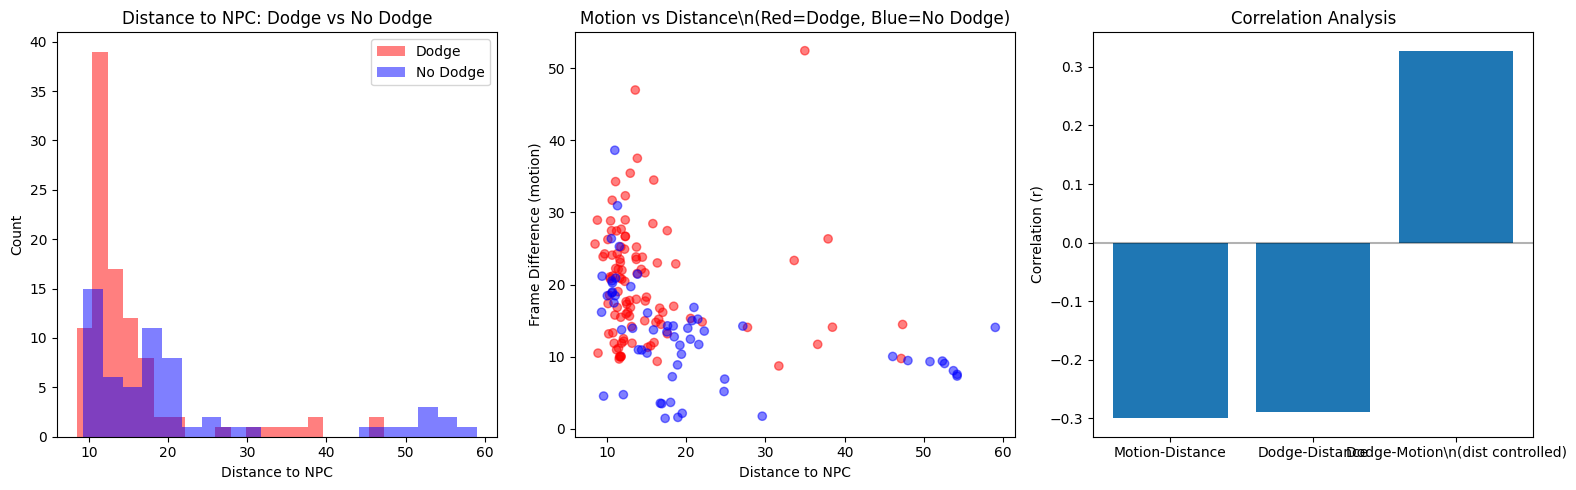


=== ANALYSIS ===
Motion ↔ Distance: r=-0.300 (p=0.0001)
Dodge ↔ Distance: r=-0.290 (p=0.0002)
Dodge ↔ Motion (controlling for distance): r=0.328 (p=0.0000)

→ Motion signal EXISTS even after controlling for distance!


In [71]:
# Test hypothesis: Is the signal just "close to NPC" or actual attack motion?
# Compare: full frame motion vs distance to NPC

# Get distance to NPC for each example
def get_distance_to_npc(state):
    """Calculate distance between hero and NPC from state."""
    hero_x, hero_y, hero_z = state[6], state[7], state[8]  # HeroGlobalPos X,Y,Z
    npc_x, npc_y, npc_z = state[14], state[15], state[16]  # NpcGlobalPos X,Y,Z
    return np.sqrt((hero_x - npc_x)**2 + (hero_y - npc_y)**2 + (hero_z - npc_z)**2)

# Collect: frame_diff, distance, is_dodge for analysis
data_points = []

print("Collecting motion + distance data...")
for ep_name, onset_frame in dodge_examples[:100]:
    ep = zarr_root[ep_name]
    frames = ep['frames']
    state = ep['state']
    if onset_frame >= 5:
        diff = frame_difference(frames[onset_frame-5], frames[onset_frame-1]).mean()
        dist = get_distance_to_npc(state[onset_frame])
        data_points.append({'diff': diff, 'dist': dist, 'dodge': 1})

for ep_name, frame_idx in no_dodge_examples[:100]:
    ep = zarr_root[ep_name]
    frames = ep['frames']
    state = ep['state']
    if frame_idx >= 5:
        diff = frame_difference(frames[frame_idx-5], frames[frame_idx-1]).mean()
        dist = get_distance_to_npc(state[frame_idx])
        data_points.append({'diff': diff, 'dist': dist, 'dodge': 0})

import pandas as pd
df = pd.DataFrame(data_points)

# Plot: Distance vs Frame Diff, colored by dodge
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Distance distribution
axes[0].hist(df[df['dodge']==1]['dist'], bins=20, alpha=0.5, label='Dodge', color='red')
axes[0].hist(df[df['dodge']==0]['dist'], bins=20, alpha=0.5, label='No Dodge', color='blue')
axes[0].set_xlabel('Distance to NPC')
axes[0].set_ylabel('Count')
axes[0].set_title('Distance to NPC: Dodge vs No Dodge')
axes[0].legend()

# 2. Frame diff vs distance scatter
colors = ['red' if d else 'blue' for d in df['dodge']]
axes[1].scatter(df['dist'], df['diff'], c=colors, alpha=0.5)
axes[1].set_xlabel('Distance to NPC')
axes[1].set_ylabel('Frame Difference (motion)')
axes[1].set_title('Motion vs Distance\\n(Red=Dodge, Blue=No Dodge)')

# 3. Correlation analysis
from scipy.stats import pearsonr, spearmanr

# Is motion correlated with distance?
r_motion_dist, p_motion_dist = pearsonr(df['diff'], df['dist'])
# Is dodge correlated with distance?
r_dodge_dist, p_dodge_dist = pearsonr(df['dodge'], df['dist'])
# Is dodge correlated with motion, controlling for distance?
# Partial correlation: regress out distance

from scipy.stats import linregress
# Residualize motion w.r.t. distance
slope, intercept, _, _, _ = linregress(df['dist'], df['diff'])
df['diff_residual'] = df['diff'] - (slope * df['dist'] + intercept)
r_dodge_motion_residual, p_residual = pearsonr(df['dodge'], df['diff_residual'])

axes[2].bar(['Motion-Distance', 'Dodge-Distance', 'Dodge-Motion\\n(dist controlled)'], 
            [r_motion_dist, r_dodge_dist, r_dodge_motion_residual])
axes[2].set_ylabel('Correlation (r)')
axes[2].set_title('Correlation Analysis')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== ANALYSIS ===")
print(f"Motion ↔ Distance: r={r_motion_dist:.3f} (p={p_motion_dist:.4f})")
print(f"Dodge ↔ Distance: r={r_dodge_dist:.3f} (p={p_dodge_dist:.4f})")
print(f"Dodge ↔ Motion (controlling for distance): r={r_dodge_motion_residual:.3f} (p={p_residual:.4f})")

if abs(r_dodge_dist) > 0.3 and abs(r_dodge_motion_residual) < 0.1:
    print("\n→ CONFIRMED: Signal is mostly 'close to NPC', not attack-specific motion")
elif abs(r_dodge_motion_residual) > 0.1:
    print("\n→ Motion signal EXISTS even after controlling for distance!")
else:
    print("\n→ Mixed signal - both distance and motion matter")

In [72]:
# Analyze: When in an NPC animation do players dodge?
# For each dodge, find: which anim is playing, how many frames since that anim started

from collections import defaultdict

# Collect dodge timing relative to animation onset
# Key: anim_id, Value: list of "frames since anim started" when dodge happened
dodge_timing_by_anim = defaultdict(list)

print("Analyzing dodge timing relative to NPC animation onset...")

for ep_name in tqdm(episodes):
    ep = zarr_root[ep_name]
    actions = ep['actions'][:]
    state = ep['state'][:]
    
    npc_anims = state[:, NPC_ANIM_IDX].astype(int)
    dodges = actions[:, DODGE_IDX]
    
    # Track animation onsets
    current_anim = None
    anim_start_frame = 0
    
    for frame_idx in range(len(npc_anims)):
        anim = npc_anims[frame_idx]
        
        # Detect animation change (onset)
        if anim != current_anim:
            current_anim = anim
            anim_start_frame = frame_idx
        
        # If dodge happens, record timing
        if dodges[frame_idx]:
            frames_since_anim_start = frame_idx - anim_start_frame
            dodge_timing_by_anim[current_anim].append(frames_since_anim_start)

# Get top animations by dodge count
top_dodge_anims = sorted(dodge_timing_by_anim.items(), key=lambda x: len(x[1]), reverse=True)[:10]

print(f"\nTop 10 NPC animations by dodge count:")
for anim, timings in top_dodge_anims:
    print(f"  Anim {anim}: {len(timings)} dodges, mean timing: {np.mean(timings):.1f} frames")

Analyzing dodge timing relative to NPC animation onset...


100%|██████████| 100/100 [00:00<00:00, 155.84it/s]


Top 10 NPC animations by dodge count:
  Anim 2003017: 835 dodges, mean timing: 18.0 frames
  Anim 2003022: 538 dodges, mean timing: 25.6 frames
  Anim 2002000: 369 dodges, mean timing: 29.8 frames
  Anim 2003027: 287 dodges, mean timing: 25.0 frames
  Anim 2003029: 278 dodges, mean timing: 26.7 frames
  Anim 2009000: 272 dodges, mean timing: 11.7 frames
  Anim 41002: 269 dodges, mean timing: 8.6 frames
  Anim 2003033: 261 dodges, mean timing: 13.8 frames
  Anim 2003000: 222 dodges, mean timing: 22.0 frames
  Anim 2003006: 199 dodges, mean timing: 14.0 frames


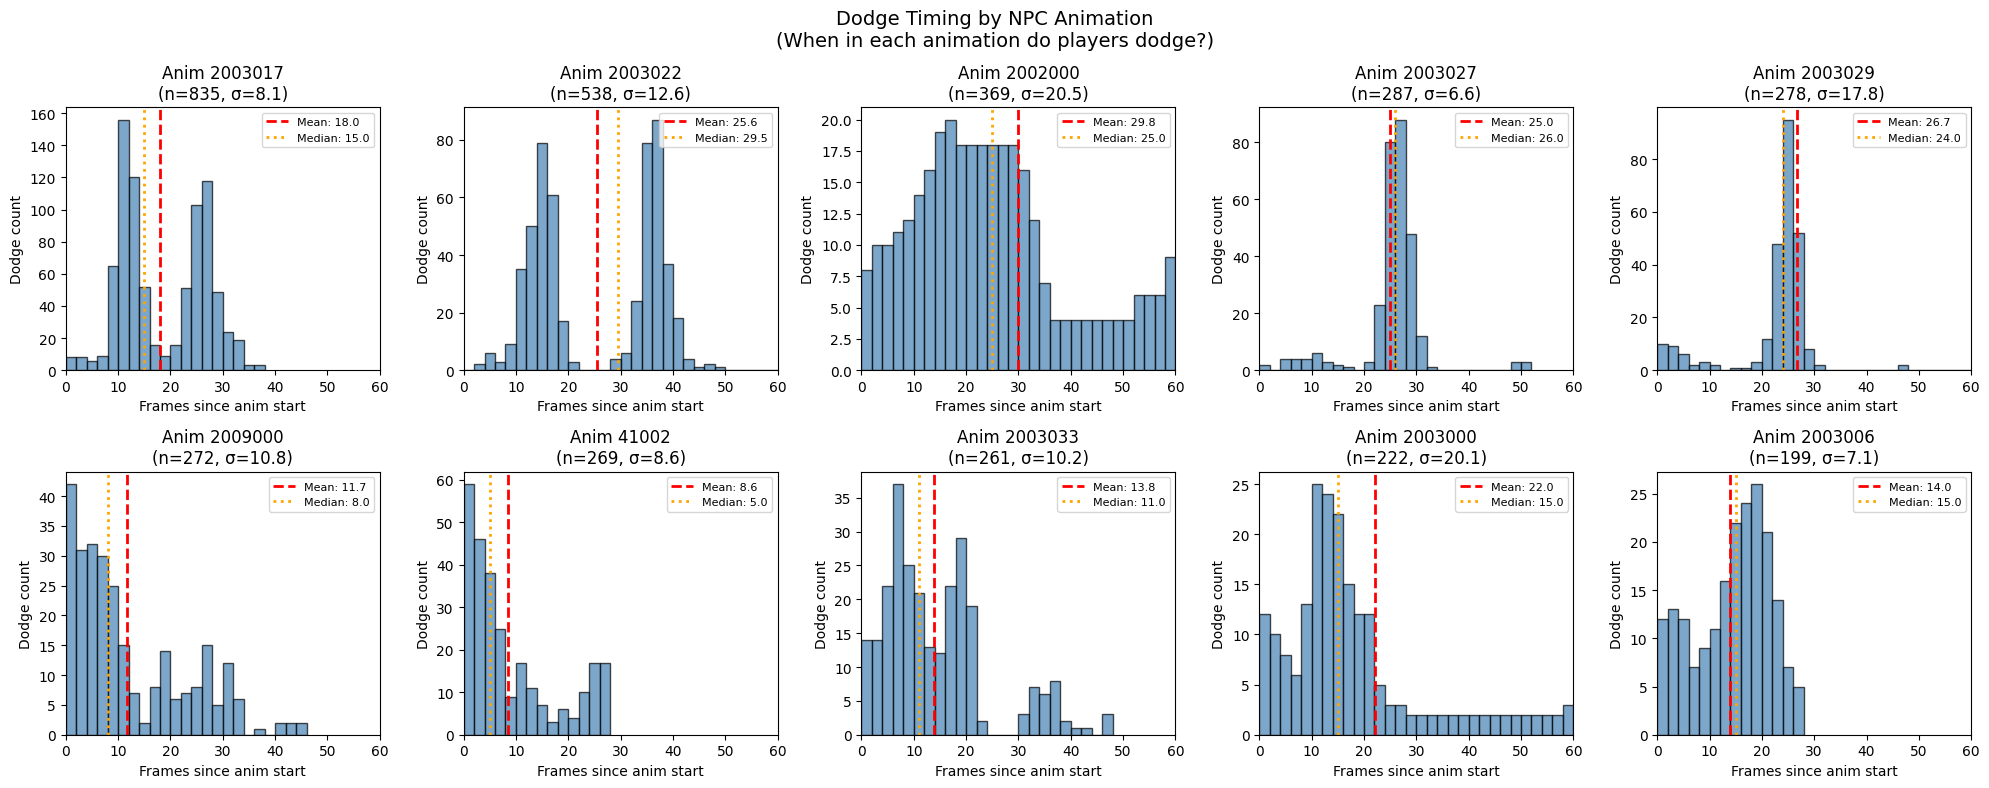


=== Dodge Timing Statistics by Animation ===
     Anim ID |  Count |     Mean |      Std |   Median |   Mode Range
----------------------------------------------------------------------
     2003017 |    835 |     18.0 |      8.1 |     15.0 |         8-12
     2003022 |    538 |     25.6 |     12.6 |     29.5 |        12-16
     2002000 |    369 |     29.8 |     20.5 |     25.0 |        16-20
     2003027 |    287 |     25.0 |      6.6 |     26.0 |        24-28
     2003029 |    278 |     26.7 |     17.8 |     24.0 |        24-28
     2009000 |    272 |     11.7 |     10.8 |      8.0 |          0-4
       41002 |    269 |      8.6 |      8.6 |      5.0 |          0-4
     2003033 |    261 |     13.8 |     10.2 |     11.0 |          4-8
     2003000 |    222 |     22.0 |     20.1 |     15.0 |        12-16
     2003006 |    199 |     14.0 |      7.1 |     15.0 |        16-20

=== INTERPRETATION ===
If std is LOW (< 10): Player dodges at consistent timing → learnable pattern
If std is HI

In [73]:
# Visualize dodge timing histograms for top 10 animations
# Shows: when in each animation do players typically dodge?

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (anim_id, timings) in enumerate(top_dodge_anims):
    ax = axes[idx]
    
    # Plot histogram
    if len(timings) > 0:
        max_timing = min(60, max(timings))  # Cap at 60 frames for visualization
        bins = np.arange(0, max_timing + 2, 2)  # 2-frame bins
        ax.hist(timings, bins=bins, color='steelblue', edgecolor='black', alpha=0.7)
        
        # Add statistics
        mean_timing = np.mean(timings)
        std_timing = np.std(timings)
        median_timing = np.median(timings)
        
        ax.axvline(mean_timing, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_timing:.1f}')
        ax.axvline(median_timing, color='orange', linestyle=':', linewidth=2, label=f'Median: {median_timing:.1f}')
        
        ax.set_title(f'Anim {anim_id}\n(n={len(timings)}, σ={std_timing:.1f})')
        ax.set_xlabel('Frames since anim start')
        ax.set_ylabel('Dodge count')
        ax.legend(fontsize=8)
        ax.set_xlim(0, 60)

plt.suptitle('Dodge Timing by NPC Animation\n(When in each animation do players dodge?)', fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics table
print("\n=== Dodge Timing Statistics by Animation ===")
print(f"{'Anim ID':>12} | {'Count':>6} | {'Mean':>8} | {'Std':>8} | {'Median':>8} | {'Mode Range':>12}")
print("-" * 70)

for anim_id, timings in top_dodge_anims:
    if len(timings) > 0:
        mean_t = np.mean(timings)
        std_t = np.std(timings)
        median_t = np.median(timings)
        
        # Find mode range (most common timing window)
        hist, bin_edges = np.histogram(timings, bins=np.arange(0, 62, 4))
        mode_idx = np.argmax(hist)
        mode_range = f"{int(bin_edges[mode_idx])}-{int(bin_edges[mode_idx+1])}"
        
        print(f"{anim_id:>12} | {len(timings):>6} | {mean_t:>8.1f} | {std_t:>8.1f} | {median_t:>8.1f} | {mode_range:>12}")

# Interpretation
print("\n=== INTERPRETATION ===")
print("If std is LOW (< 10): Player dodges at consistent timing → learnable pattern")
print("If std is HIGH (> 15): Variable timing → harder to learn, may need visual cues")
print("\nLow-std animations are best candidates for animation-based dodge prediction.")